In [4]:
!pip install arch

In [5]:
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

In [6]:
# Get the data for Tata Motors
ticker = "TCS.NS"

# Download the data
data = yf.download(ticker, start="2021-04-01", end="2024-03-31")

[*********************100%%**********************]  1 of 1 completed


                      Constant Mean - ARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1244.55
Distribution:                  Normal   AIC:                           2495.10
Method:            Maximum Likelihood   BIC:                           2508.92
                                        No. Observations:                  739
Date:                Thu, Jul 25 2024   Df Residuals:                      738
Time:                        18:44:15   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0442  4.711e-02      0.937      0.349 [-4.81

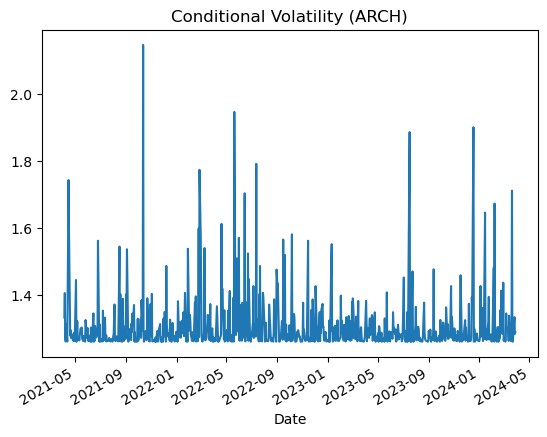

In [7]:
# Create 'Returns' column
data['Returns'] = 100 * data['Adj Close'].pct_change().dropna()

# Fit an ARCH model
arch_model_fit = arch_model(data['Returns'].dropna(), vol='ARCH', p=1).fit(disp='off')
print(arch_model_fit.summary())

# Plot the conditional volatility
arch_model_fit.conditional_volatility.plot(title='Conditional Volatility (ARCH)')
plt.show()

In [ ]:
# Drop NaN values from 'Returns'
returns = data['Returns'].dropna()

# Fit a GARCH model
garch_model_fit = arch_model(returns, vol='Garch', p=1, q=1).fit(disp='off')
print(garch_model_fit.summary())

# Plot the conditional volatility
garch_model_fit.conditional_volatility.plot(title='Conditional Volatility (GARCH)')
plt.show()

In [ ]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(update_freq=10)

In [ ]:
forecasts = res.forecast()

In [ ]:
type(forecasts)

In [ ]:
data.tail()

In [ ]:
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

In [ ]:
forecasts = res.forecast(horizon=90)
print(forecasts.residual_variance.iloc[-3:])

In [ ]:
forecasts.residual_variance

In [ ]:
fig = res.plot(annualize="D")

## PART B: VAR, VECM Models on commodity prices

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [15]:
# Set working directory
import os
os.chdir('/Users/kirthanshaker/Desktop/SCMA 631 Data Files ')
print(os.getcwd())

/Users/kirthanshaker/Desktop/SCMA 631 Data Files 


In [17]:
# Load the data
df = pd.read_excel('/Users/kirthanshaker/Desktop/SCMA 631 Data Files /pinksheet.xlsx', sheet_name="Monthly Prices", skiprows=6)

In [18]:
df

,Unnamed: 0,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,CRUDE_WTI,COAL_AUS,COAL_SAFRICA,NGAS_US,NGAS_EUR,NGAS_JP,...,ALUMINUM,IRON_ORE,COPPER,LEAD,Tin,NICKEL,Zinc,GOLD,PLATINUM,SILVER
0,1960M01,1.630000,1.630,1.63,…,…,…,0.1400,0.404774,…,...,511.471832,11.42,715.40,206.10,2180.40,1631.00,260.80,35.27,83.50,0.9137
1,1960M02,1.630000,1.630,1.63,…,…,…,0.1400,0.404774,…,...,511.471832,11.42,728.19,203.70,2180.40,1631.00,244.90,35.27,83.50,0.9137
2,1960M03,1.630000,1.630,1.63,…,…,…,0.1400,0.404774,…,...,511.471832,11.42,684.94,210.30,2173.80,1631.00,248.70,35.27,83.50,0.9137
3,1960M04,1.630000,1.630,1.63,…,…,…,0.1400,0.404774,…,...,511.471832,11.42,723.11,213.60,2178.20,1631.00,254.60,35.27,83.50,0.9137
4,1960M05,1.630000,1.630,1.63,…,…,…,0.1400,0.404774,…,...,511.471832,11.42,684.75,213.40,2162.70,1631.00,253.80,35.27,83.50,0.9137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,2024M02,80.548000,83.764,81.18,76.7,124.22,105.193,1.7211,8.148381,13.644993,...,2179.460000,124.39,8304.95,2079.83,26104.10,16338.46,2360.09,2023.24,894.29,22.6570
770,2024M03,83.545667,85.447,84.70,80.49,131.49,104.84,1.4999,8.553726,13.185629,...,2226.160000,109.79,8689.13,2056.20,27450.46,17438.83,2461.04,2158.01,908.75,24.5180
771,2024M04,88.011333,90.054,89.39,84.59,134.97,104.89,1.5967,9.085119,11.87777,...,2506.100000,112.75,9464.43,2129.46,31774.50,18163.95,2732.74,2331.45,940.18,27.4940
772,2024M05,81.445000,81.995,83.53,78.81,142.01,105.63,2.1314,10.123066,12.162896,...,2564.540000,118.88,10139.33,2220.81,32977.51,19586.98,2959.13,2351.13,1014.68,29.3600


In [19]:
print(list(df.columns))

['Unnamed: 0', 'CRUDE_PETRO', 'CRUDE_BRENT', 'CRUDE_DUBAI', 'CRUDE_WTI', 'COAL_AUS', 'COAL_SAFRICA', 'NGAS_US', 'NGAS_EUR', 'NGAS_JP', 'iNATGAS', 'COCOA', 'COFFEE_ARABIC', 'COFFEE_ROBUS', 'TEA_AVG', 'TEA_COLOMBO', 'TEA_KOLKATA', 'TEA_MOMBASA', 'COCONUT_OIL', 'GRNUT', 'FISH_MEAL', 'GRNUT_OIL', 'PALM_OIL', 'PLMKRNL_OIL', 'SOYBEANS', 'SOYBEAN_OIL', 'SOYBEAN_MEAL', 'RAPESEED_OIL', 'SUNFLOWER_OIL', 'BARLEY', 'MAIZE', 'SORGHUM', 'RICE_05', 'RICE_25', 'RICE_A1', 'RICE_05_VNM', 'WHEAT_US_SRW', 'WHEAT_US_HRW', 'BANANA_EU', 'BANANA_US', 'ORANGE', 'BEEF', 'CHICKEN', 'LAMB', 'SHRIMP_MEX', 'SUGAR_EU', 'SUGAR_US', 'SUGAR_WLD', 'TOBAC_US', 'LOGS_CMR', 'LOGS_MYS', 'SAWNWD_CMR', 'SAWNWD_MYS', 'PLYWOOD', 'COTTON_A_INDX', 'RUBBER_TSR20', 'RUBBER1_MYSG', 'PHOSROCK', 'DAP', 'TSP', 'UREA_EE_BULK', 'POTASH', 'ALUMINUM', 'IRON_ORE', 'COPPER', 'LEAD', 'Tin', 'NICKEL', 'Zinc', 'GOLD', 'PLATINUM', 'SILVER']


In [20]:
# Rename the first column to "Date"
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

In [21]:
df.Date

0      1960M01
1      1960M02
2      1960M03
3      1960M04
4      1960M05
        ...   
769    2024M02
770    2024M03
771    2024M04
772    2024M05
773    2024M06
Name: Date, Length: 774, dtype: object

In [22]:
# Convert the Date column to datetime format
def parse_date(date_str):
    # Split the string by 'M' to separate year and month
    year, month = date_str.split('M')
    # Create a date string in the format 'YYYY-MM-01'
    return f"{year}-{month}-01"

df['Date'] = pd.to_datetime(df['Date'].apply(parse_date))

# Print the data types to confirm the conversion
print(df.dtypes)

Date           datetime64[ns]
CRUDE_PETRO           float64
CRUDE_BRENT           float64
CRUDE_DUBAI           float64
CRUDE_WTI              object
                    ...      
NICKEL                float64
Zinc                  float64
GOLD                  float64
PLATINUM              float64
SILVER                float64
Length: 72, dtype: object


In [23]:
df.Date

0     1960-01-01
1     1960-02-01
2     1960-03-01
3     1960-04-01
4     1960-05-01
         ...    
769   2024-02-01
770   2024-03-01
771   2024-04-01
772   2024-05-01
773   2024-06-01
Name: Date, Length: 774, dtype: datetime64[ns]

In [24]:
# Select specific columns (Date and selected commodities)
commodity = df.iloc[:, [0, 2, 24, 69, 71, 60, 30]]
commodity.columns = [col.lower().replace(' ', '_') for col in commodity.columns]  # Clean column names

print(commodity.dtypes)

date            datetime64[ns]
crude_brent            float64
soybeans               float64
gold                   float64
silver                 float64
urea_ee_bulk           float64
maize                  float64
dtype: object


In [25]:
# Remove the Date column for analysis
commodity_data = commodity.drop(columns=['date'])

# Column names to test
columns_to_test = commodity_data.columns

In [26]:
# Initialize counters and lists for stationary and non-stationary columns
non_stationary_count = 0
stationary_columns = []
non_stationary_columns = []

In [27]:
# Loop through each column and perform the ADF test
for col in columns_to_test:
    adf_result = adfuller(commodity_data[col])
    p_value = adf_result[1]  # Extract p-value for the test
    print(f"\nADF test result for column: {col}")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {p_value}")
    
    # Check if the p-value is greater than 0.05 (commonly used threshold)
    if p_value > 0.05:
        non_stationary_count += 1
        non_stationary_columns.append(col)
    else:
        stationary_columns.append(col)


ADF test result for column: crude_brent
ADF Statistic: -1.5078661910935434
p-value: 0.5296165197702354

ADF test result for column: soybeans
ADF Statistic: -2.4231464527418884
p-value: 0.13530977427790436

ADF test result for column: gold
ADF Statistic: 1.3430517021933006
p-value: 0.9968394353612382

ADF test result for column: silver
ADF Statistic: -1.3972947107462244
p-value: 0.5835723787985752

ADF test result for column: urea_ee_bulk
ADF Statistic: -2.5101716315209086
p-value: 0.11301903181624645

ADF test result for column: maize
ADF Statistic: -2.4700451060920465
p-value: 0.12293380919376656


In [28]:
# Print the number of non-stationary columns and the lists of stationary and non-stationary columns
print(f"\nNumber of non-stationary columns: {non_stationary_count}")
print(f"Non-stationary columns: {non_stationary_columns}")
print(f"Stationary columns: {stationary_columns}")



Number of non-stationary columns: 6
Non-stationary columns: ['crude_brent', 'soybeans', 'gold', 'silver', 'urea_ee_bulk', 'maize']
Stationary columns: []


In [29]:
# Co-Integration Test (Johansen's Test)
def johansen_test(df, alpha=0.05):
    out = coint_johansen(df, det_order=0, k_ar_diff=1)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1 - alpha)]]
    print(f"Trace statistic: {traces}")
    print(f"Critical values: {cvts}")
    print(f"Eigenvalues: {out.eig}")
    for col, trace, cvt in zip(df.columns, traces, cvts):
        if trace > cvt:
            print(f"{col} is cointegrated.")
        else:
            print(f"{col} is not cointegrated.")
    return out

In [30]:
# Perform Johansen cointegration test
coint_test = johansen_test(commodity_data)

Trace statistic: [261.5548149  167.67790177  98.11781369  53.4617083   21.6404865
   4.01416422]
Critical values: [95.7542 69.8189 47.8545 29.7961 15.4943  3.8415]
Eigenvalues: [0.11449947 0.08616362 0.05620349 0.04038124 0.02257335 0.0051862 ]
crude_brent is cointegrated.
soybeans is cointegrated.
gold is cointegrated.
silver is cointegrated.
urea_ee_bulk is cointegrated.
maize is cointegrated.


In [31]:
# Number of cointegrating relationships (assuming r = 1 if there's at least one significant eigenvalue)
r = sum(coint_test.lr1 > coint_test.cvt[:, 1])  # Replace with the actual number from the test results

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Jul, 2024
Time:                     18:51:56
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    26.7336
Nobs:                     768.000    HQIC:                   25.9079
Log likelihood:          -16066.7    FPE:                1.06530e+11
AIC:                      25.3912    Det(Omega_mle):     8.03276e+10
--------------------------------------------------------------------
Results for equation crude_brent
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.574387         0.457999           -1.254           0.210
L1.crude_brent          1.288559         0.039600           32.539           0.000
L1.soybeans             0.011187         0.007

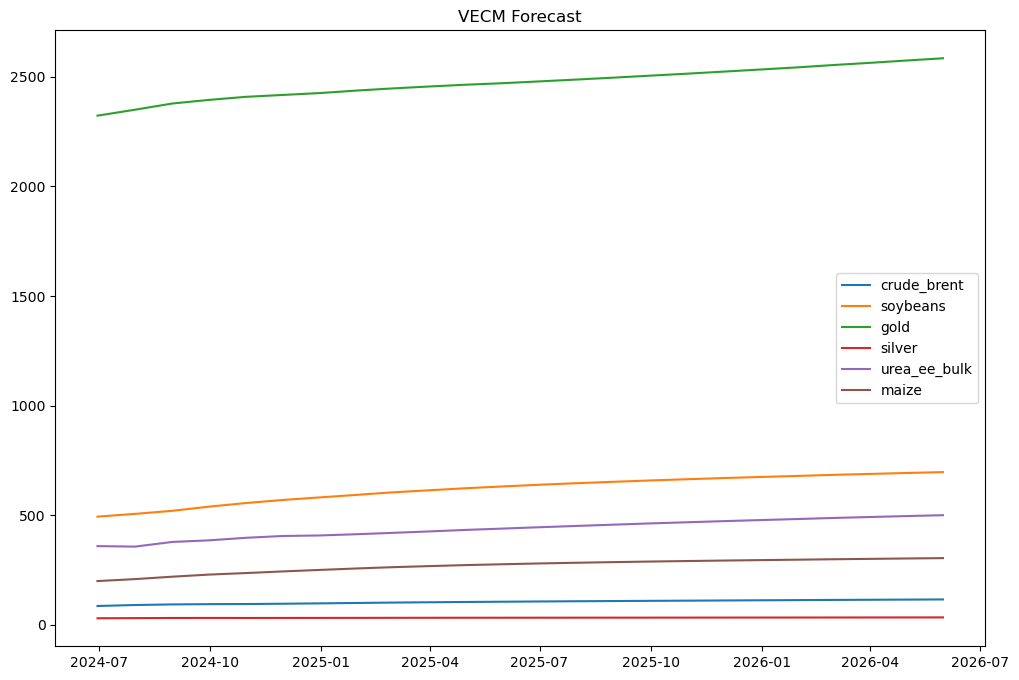

In [32]:
if r > 0:
    # Creating a VAR model for prediction using the VECM
    model = VAR(commodity_data)
    vecm_result = model.fit(r)
    
    # Summary of the VECM model
    print(vecm_result.summary())
    
    # Forecasting using the VECM model
    # Forecasting 24 steps ahead
    forecast = vecm_result.forecast(commodity_data.values[-vecm_result.k_ar:], steps=24)
    
    # Convert forecast to DataFrame for plotting
    forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=commodity['date'].iloc[-1], periods=24, freq='M'), columns=commodity_data.columns)
    
    # Plotting the forecast
    plt.figure(figsize=(12, 8))
    for col in forecast_df.columns:
        plt.plot(forecast_df.index, forecast_df[col], label=col)
    plt.legend()
    plt.title('VECM Forecast')
    plt.show()

else:
    # If no co-integration exists, proceed with Unrestricted VAR Analysis
    model = VAR(commodity_data)
    var_result = model.fit(maxlags=10, ic='aic')
    
    # Summary of the VAR model
    print(var_result.summary())
    
    # Granger causality test
    causality_results = {}
    for col in commodity_data.columns:
        causality_results[col] = var_result.test_causality(causing=col, caused=commodity_data.columns.difference([col]), kind='f').summary()
    print(causality_results)
    
    # Forecasting using the VAR model
    forecast = var_result.forecast(commodity_data.values[-var_result.k_ar:], steps=24)
    
    # Convert forecast to DataFrame for plotting
    forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=commodity['date'].iloc[-1], periods=24, freq='M'), columns=commodity_data.columns)
    
    # Plotting the forecast
    plt.figure(figsize=(12, 8))
    for col in forecast_df.columns:
        plt.plot(forecast_df.index, forecast_df[col], label=col)
    plt.legend()
    plt.title('VAR Forecast')
    plt.show()